# GSEA with gseapy

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils
from scripts.analysis import build_loci

In [2]:
BASE = '../data'

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt1.pkl.gz"))
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci_filt1.pkl.gz"))

In [3]:
import gseapy as gp
import goatools

obodag = goatools.obo_parser.GODag('go-basic.obo')

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-07-16) 46,953 GO Terms


In [4]:
def make_ranked_df(grouped_loci):
    df = build_loci.get_sig_df(grouped_loci)
    
    # set insiginifcant loci to the center rank of the gene list
    df['logfc'] = df.where((abs(df['logfc']) <= 2) | (df['p_value'] <= 0.05))['logfc'].replace(np.nan, 0)
    
    # Right now FC ratios are light/heavy
    # light == Tcell and heavy == RAG
    # GSEA goes from low to High, so negative logFC values will come first
    # This will give genes high in RAG highest priority
    # Switching the sign with put the genes highest in Tcell mice up first
    df['logfc'] = -1 * df['logfc']
    
    # filter out the mouse and human genes
    mh_loci = build_loci.get_annotation_df(grouped_loci).query('mouse_human').index.tolist()
    df = df.query('~(id in {})'.format(mh_loci))

    
    # prep the ranking dataframe to gesapy specs.
    rank_df = df[['id', 'logfc']].rename(columns={'id': 'gene_name', 'logfc': 'rank'})
    
    return rank_df.sort_values('rank').reset_index(drop=True)


In [5]:
def make_go2Gene_map(grouped_loci, ontology='MF'):
    ontology_map = {'MF': 'molecular_function', 'BP': 'biological_process', 'CC': 'cellular_component'}
    
    out = defaultdict(set)    
    for l in grouped_loci:
        if 'go' in l.annotations and l.avg_ratio != 0:
            for go in l.annotations['go']:
                if obodag[go].namespace == ontology_map[ontology]:
                    out[go].add(l.cluster_id)
                    for parent in obodag[go].get_all_parents():
                        if obodag[parent].namespace == ontology_map[ontology]:
                            out[parent].add(l.cluster_id)
                
    return out

In [6]:
def filter_go2gene_map(go_locus):
    
    # Remove "very broad" gene sets. Arbitrary definition: gene sets that emcompass >50% of all IDs
    all_ids = set(chain(*go_locus.values()))
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) / len(all_ids) <= 0.5}

    # Remove terms with less than 5 members: changed from 10 to 5 becasue small #s of proteins compared
    # to what you would find wiht genes
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) >= 5}

    # Remove child terms with identical gene sets as their parents
    to_remove = set()
    for parent in go_locus.keys():
        # If child term has exact same members as parent, remove
        child_ids = [x.id for x in obodag[parent].children if x.id in go_locus.keys()]
        for child in child_ids:
            if go_locus[child] == go_locus[parent]:
                to_remove.add(child)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    # Remove sibling terms with identical gene sets
    to_remove = set()
    for brother in go_locus.keys():
        for parent in obodag[brother].parents:
            siblings = set([y.id for y in parent.children])
            siblings.remove(brother)
            for sibling in siblings:
                if sibling in go_locus.keys() and go_locus[brother] == go_locus[sibling]:
                    to_remove.add(sibling)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    return go_locus

In [7]:
def gomap_to_csv(go2gene, out_file = 'test.tsv'):

    out = ""
    for term, loci in go2gene.items():
        out += "{}\t".format(term)
        out += "{}\t".format(obodag[term].name)
        out += '\t'.join(list(map(str,loci)))
        out += '\n'
        
    with open(out_file, 'w') as fout:
        fout.write(out)

In [8]:
def run_go_gsea(rank_df, g2g_map):
    """
    A ranked df and go2gene mapping returns the result dataframe for GSEA against all go-Terms
    
    loci must be grouped such that avg_ratio and p-values are correct for 1 phenotype
    see rt_unenr_grouped_loci above for example
    """
    import gseapy as gp
        
    # save the go 2 gene map, since gseapy doesn't seem to be able to use one already in memory
    gomap_to_csv(g2g_map, 'temp.gmt')
    
    res = gp.prerank(rnk=rank_df, gene_sets='temp.gmt', outdir='tmp', min_size = 5, max_size=500, graph_num = len(g2g_map), savefigs=False)
      
    def get_go_name(term):
        return obodag[term].name
    
    res['name'] = res.index.map(get_go_name)
    
    return res.sort_values('nes', ascending=False)

In [9]:
def plot_gsea_result(row, rank):
    return gp.gsea_plot.gsea_plot(rank, row['name'], row.hit_index, row.nes, row.pval, row.fdr, row.rank_ES, phenoPos='Tcell', phenoNeg='RAG')

In [10]:
mf_map = make_go2Gene_map(unenr_grouped_loci)
mf_map_f = filter_go2gene_map(mf_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(mf_map), len(mf_map_f)))

Unfiltered: 516	Filtered: 196


In [11]:
bp_map = make_go2Gene_map(unenr_grouped_loci, 'BP')
bp_map_f = filter_go2gene_map(bp_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(bp_map), len(bp_map_f)))

Unfiltered: 612	Filtered: 196


In [12]:
unen_rank =  make_ranked_df(unenr_grouped_loci)

In [13]:
import warnings
warnings.filterwarnings('ignore')

mf_un_res = run_go_gsea(unen_rank, mf_map_f)
bp_un_res = run_go_gsea(unen_rank, bp_map_f)

117 gene_sets have been filtered out when max_size=500 and min_size=5
79 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Sep 21 16:18:40 2016
Start to compute esnulls................................ Wed Sep 21 16:18:40 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Wed Sep 21 16:18:52 2016
start to compute fdrs................................... Wed Sep 21 16:18:52 2016
Statistial testing finished............................. Wed Sep 21 16:18:52 2016
Start to generate gseapy reports, and produce figures... Wed Sep 21 16:18:52 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Wed Sep 21 16:18:52 2016
95 gene_sets have been filtered out when max_size=500 and min_size=5
101 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Sep 21 16:18:54 2016
Start 

In [14]:
mf_un_TC = mf_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_un_RAG = mf_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_un_TC = bp_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_un_RAG = bp_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Molecular Function - Up in Tcell

In [15]:
res_cols = ['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']

In [16]:
mf_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016853,isomerase activity,0.797125,3.012020,0.000000,0.000201,141,89
GO:0016860,intramolecular oxidoreductase activity,0.749289,1.978601,0.007463,0.030835,53,16
GO:0051287,NAD binding,0.646336,1.899821,0.007117,0.038025,39,24
GO:0016614,"oxidoreductase activity, acting on CH-OH group...",0.543500,1.756659,0.013201,0.062572,58,32
GO:0016620,"oxidoreductase activity, acting on the aldehyd...",0.493832,1.624401,0.039301,0.103485,66,36
GO:0016829,lyase activity,0.357965,1.470020,0.033898,0.154565,210,127
GO:0016830,carbon-carbon lyase activity,0.384044,1.467723,0.037567,0.141991,111,78


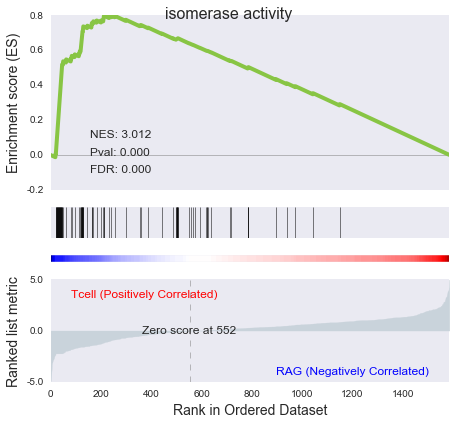

In [17]:
sns.set_style('dark')
plot_gsea_result(mf_un_res.iloc[0], unen_rank)

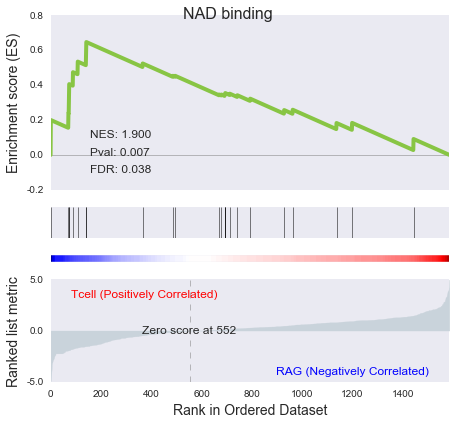

In [18]:
sns.set_style('dark')
plot_gsea_result(mf_un_res.iloc[2], unen_rank)

### Biological Process - Up in Tcell

In [19]:
bp_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0006753,nucleoside phosphate metabolic process,0.546074,2.443350,0.000000,0.001251,284,158
GO:0046939,nucleotide phosphorylation,0.617930,2.404224,0.000000,0.001486,202,132
GO:0006733,oxidoreduction coenzyme metabolic process,0.617930,2.397208,0.000000,0.001459,204,132
GO:0044712,single-organism catabolic process,0.612671,2.339803,0.000000,0.001882,227,145
GO:0009056,catabolic process,0.581914,2.329962,0.000000,0.001924,255,161
GO:0005975,carbohydrate metabolic process,0.518796,2.287661,0.000000,0.002373,499,312
GO:0044723,single-organism carbohydrate metabolic process,0.510576,2.279901,0.000000,0.002447,359,229
GO:0019637,organophosphate metabolic process,0.534250,2.278496,0.000000,0.002406,306,173
GO:0009259,ribonucleotide metabolic process,0.547762,2.232751,0.000000,0.003083,263,149


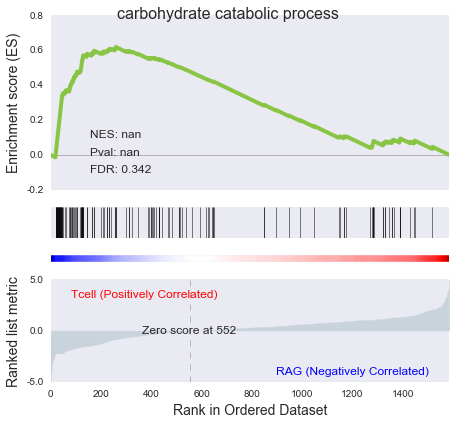

In [20]:
plot_gsea_result(bp_un_res.loc['GO:0016052'], unen_rank)

### Molecular Function - Up in RAG

In [21]:
mf_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0034062,RNA polymerase activity,-0.548793,-2.539170,0.000000,1.000000e+09,131,83
GO:0016779,nucleotidyltransferase activity,-0.488566,-2.338866,0.000000,0.000000e+00,182,118
GO:0032559,adenyl ribonucleotide binding,-0.456267,-2.176082,0.000000,0.000000e+00,412,200
GO:0030554,adenyl nucleotide binding,-0.446364,-2.128859,0.000000,0.000000e+00,417,202
GO:0016781,"phosphotransferase activity, paired acceptors",-0.453596,-2.122653,0.000000,0.000000e+00,101,73
GO:0003677,DNA binding,-0.464261,-2.078164,0.000000,0.000000e+00,134,86
GO:0016772,"transferase activity, transferring phosphorus-...",-0.373130,-1.999176,0.000000,0.000000e+00,422,258
GO:0022804,active transmembrane transporter activity,-0.671683,-1.931288,0.000000,3.604999e-05,95,34
GO:0022857,transmembrane transporter activity,-0.671683,-1.919259,0.000000,3.517072e-05,99,34


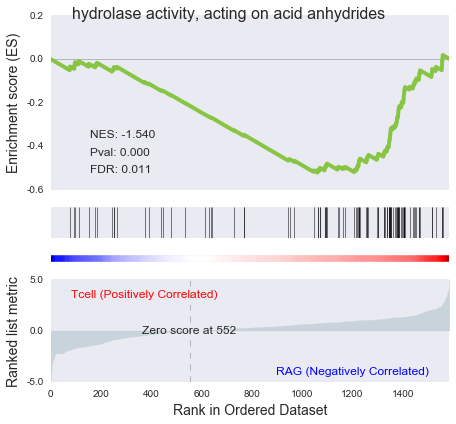

In [22]:
plot_gsea_result(mf_un_res.loc['GO:0016817'], unen_rank)

### Biological Process - Up in RAG

In [23]:
bp_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0032774,RNA biosynthetic process,-0.548793,-2.537821,0.000000,1.000000e+09,133,83
GO:0097659,nucleic acid-templated transcription,-0.548793,-2.501669,0.000000,1.000000e+09,131,83
GO:0016070,RNA metabolic process,-0.497730,-2.373794,0.000000,0.000000e+00,175,100
GO:0090304,nucleic acid metabolic process,-0.498894,-2.270740,0.000000,0.000000e+00,177,101
GO:0019438,aromatic compound biosynthetic process,-0.476334,-2.171310,0.000000,0.000000e+00,215,104
GO:1901362,organic cyclic compound biosynthetic process,-0.470114,-2.147899,0.000000,0.000000e+00,218,106
GO:0018130,heterocycle biosynthetic process,-0.470114,-2.140638,0.000000,0.000000e+00,218,106
GO:0034654,nucleobase-containing compound biosynthetic pr...,-0.478261,-2.137740,0.000000,0.000000e+00,198,97
GO:0008643,carbohydrate transport,-0.858524,-2.024170,0.000000,0.000000e+00,30,12


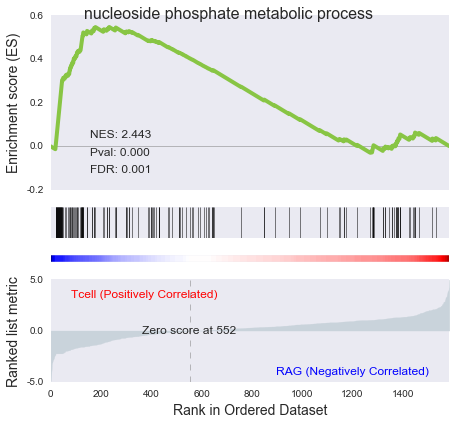

In [24]:
plot_gsea_result(bp_un_res.iloc[0], unen_rank)

## GSEA on BioGlyCMK Enriched Samples

In [25]:
enr_rank =  make_ranked_df(enr_grouped_loci)

In [26]:
# [l for l in enr_grouped_loci if l.cluster_id in enr_rank['gene_name'].tolist()]
enr_mf_map = make_go2Gene_map(enr_grouped_loci)
enr_mf_map_f = filter_go2gene_map(enr_mf_map)
print('MF Unfiltered: {}\tFiltered: {}'.format(len(enr_mf_map), len(enr_mf_map_f)))

enr_bp_map = make_go2Gene_map(enr_grouped_loci, 'BP')
enr_bp_map_f = filter_go2gene_map(enr_bp_map)
print('BP Unfiltered: {}\tFiltered: {}'.format(len(enr_bp_map), len(enr_bp_map_f)))

MF Unfiltered: 481	Filtered: 181
BP Unfiltered: 560	Filtered: 182


In [27]:
mf_enr_res = run_go_gsea(enr_rank, enr_mf_map_f)
bp_enr_res = run_go_gsea(enr_rank, enr_bp_map_f)

111 gene_sets have been filtered out when max_size=500 and min_size=5
70 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Sep 21 16:19:13 2016
Start to compute esnulls................................ Wed Sep 21 16:19:13 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Wed Sep 21 16:19:19 2016
start to compute fdrs................................... Wed Sep 21 16:19:19 2016
Statistial testing finished............................. Wed Sep 21 16:19:19 2016
Start to generate gseapy reports, and produce figures... Wed Sep 21 16:19:19 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Wed Sep 21 16:19:20 2016
104 gene_sets have been filtered out when max_size=500 and min_size=5
78 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Sep 21 16:19:21 2016
Start 

In [28]:
mf_enr_TC = mf_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_enr_RAG = mf_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_enr_TC = bp_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_enr_RAG = bp_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Up in T-Cell: Molecular Function

In [29]:
mf_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0004175,endopeptidase activity,0.857639,2.145887,0.000000,0.042680,28,10
GO:0008233,peptidase activity,0.693465,1.760255,0.000000,0.199394,69,20
GO:0005515,protein binding,0.648455,1.741567,0.023077,0.144044,70,19
GO:0016810,"hydrolase activity, acting on carbon-nitrogen ...",0.667717,1.725204,0.000000,0.116035,34,16
GO:0016787,hydrolase activity,0.391319,1.527485,0.000000,0.237539,266,112


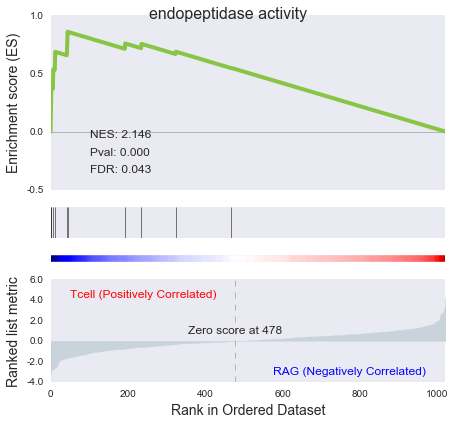

In [30]:
plot_gsea_result(mf_enr_res.loc['GO:0004175'], enr_rank)

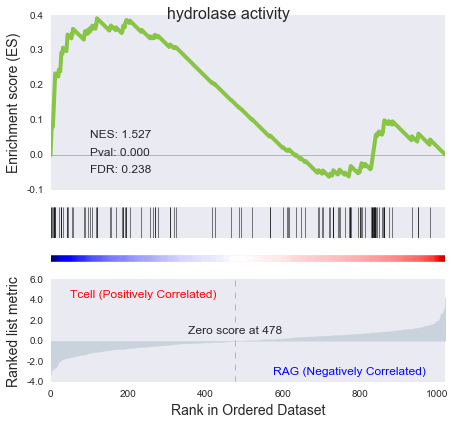

In [31]:
plot_gsea_result(mf_enr_res.loc['GO:0016787'], enr_rank)

### Up in T-Cell: Biological Process

In [32]:
bp_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0006508,proteolysis,0.671072,1.814633,0.000000,0.740461,66,21
GO:0019538,protein metabolic process,0.554955,1.798000,0.000000,0.398447,130,37
GO:0043170,macromolecule metabolic process,0.482373,1.731208,0.000000,0.349425,218,69
GO:1901605,alpha-amino acid metabolic process,0.571069,1.480252,0.018519,0.429472,36,13
GO:0009056,catabolic process,0.345026,1.335758,0.027027,0.544487,152,81
GO:0044712,single-organism catabolic process,0.345862,1.325628,0.000000,0.514887,142,80
GO:0006139,nucleobase-containing compound metabolic process,0.326851,1.297383,0.037915,0.531405,201,89


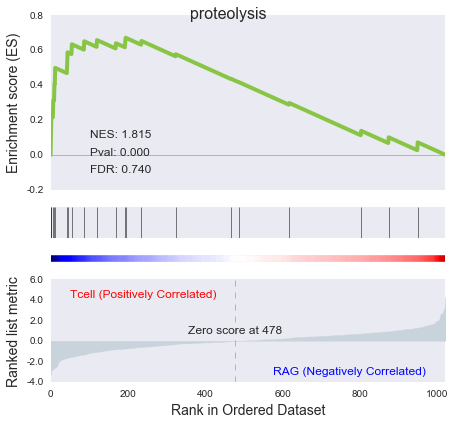

In [33]:
plot_gsea_result(bp_enr_res.loc['GO:0006508'], enr_rank)

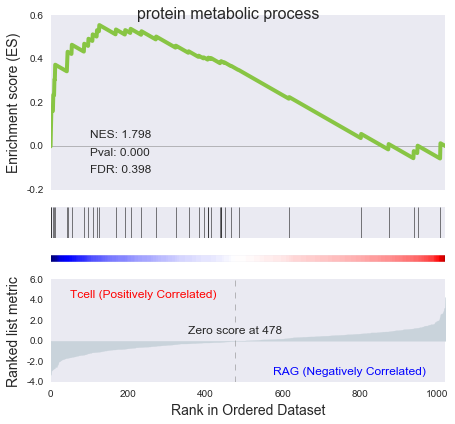

In [34]:
plot_gsea_result(bp_enr_res.loc['GO:0019538'], enr_rank)

### Up in RAG: Molecular Function

In [35]:
mf_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016781,"phosphotransferase activity, paired acceptors",-0.759528,-2.187664,0.000000,0.000000,124,38
GO:0032559,adenyl ribonucleotide binding,-0.488578,-2.071052,0.000000,0.000000,282,116
GO:0030554,adenyl nucleotide binding,-0.475972,-2.039249,0.000000,0.000000,290,119
GO:0016301,kinase activity,-0.652702,-2.029103,0.000000,0.000000,148,45
GO:0001882,nucleoside binding,-0.405086,-2.002339,0.000000,0.000271,359,150
GO:0097367,carbohydrate derivative binding,-0.405086,-1.997337,0.000000,0.000225,362,150
GO:0001883,purine nucleoside binding,-0.409370,-1.979881,0.000000,0.000193,352,146
GO:0032555,purine ribonucleotide binding,-0.409370,-1.978163,0.000000,0.000507,352,146
GO:0032553,ribonucleotide binding,-0.409370,-1.974172,0.000000,0.000451,353,146


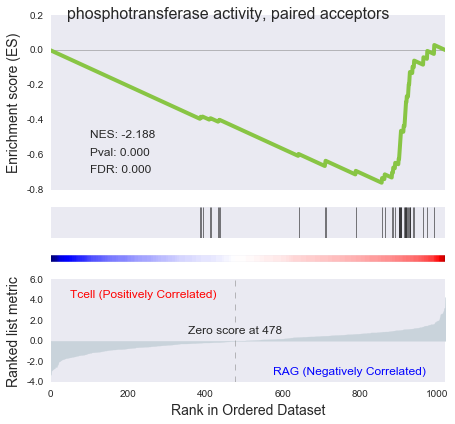

In [36]:
plot_gsea_result(mf_enr_res.loc['GO:0016781'], enr_rank)

### Up in RAG: Biological Process

In [37]:
bp_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0006457,protein folding,-0.634619,-1.688056,0.013514,0.026436,35,12
GO:0016051,carbohydrate biosynthetic process,-0.499987,-1.678210,0.003968,0.015922,71,33
GO:0044283,small molecule biosynthetic process,-0.502698,-1.579979,0.013910,0.038053,93,36
GO:0006812,cation transport,-0.609244,-1.547368,0.004717,0.040256,32,16
GO:0015672,monovalent inorganic cation transport,-0.609244,-1.530196,0.019969,0.039294,28,16
GO:0006811,ion transport,-0.609244,-1.521244,0.019878,0.034748,34,16
GO:0044255,cellular lipid metabolic process,-0.487519,-1.488004,0.000000,0.044118,41,13
GO:0006629,lipid metabolic process,-0.487519,-1.434149,0.000000,0.069546,44,13
GO:0032787,monocarboxylic acid metabolic process,-0.392058,-1.432393,0.004854,0.063020,264,117


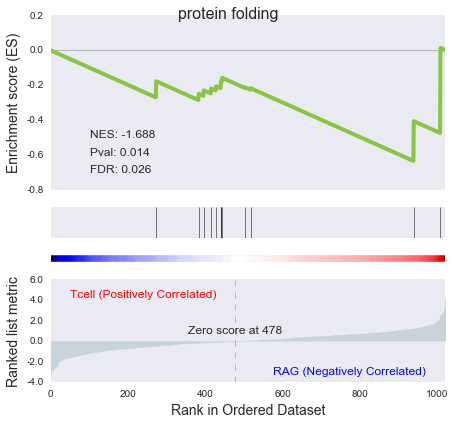

In [38]:
plot_gsea_result(bp_enr_res.loc['GO:0006457'], enr_rank)